# DP World Machine Learning Internship Assignment

objective: to build a model that predicts ETA (Estimated Time of Arrival) for DoorDash orders.

dataset link : https://www.kaggle.com/datasets/dharun4772/doordash-eta-prediction?resource=download

bare minimum requirements are
- Data processing and feature engineering
- Model training and selection
- Model inference code block 

Steps to be followed:
1. Data processing
2. Feature Engineering
3. Model Training
4. Model Inference

## 1. Data Processing

- Load the dataset.
- Explore the dataset to understand its structure.
- Check for missing values, data types, and basic statistics.

### Importing Libraries

In [1]:
!conda install -c conda-forge xgboost -y

done
Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::scrapy==2.8.0=py310hecd8cb5_0
  - defaults/osx-64::sphinx==5.0.2=py310hecd8cb5_0
  - defaults/osx-64::scikit-image==0.19.3=py310hcec6c5f_1
  - defaults/osx-64::parsel==1.6.0=py310hecd8cb5_0
  - defaults/osx-64::imbalanced-learn==0.10.1=py310hecd8cb5_0
  - defaults/osx-64::anaconda-client==1.11.1=py310hecd8cb5_0
  - defaults/noarch::requests-file==1.5.1=pyhd3eb1b0_0
  - defaults/osx-64::twisted==22.2.0=py310hca72f7f_1
  - defaults/osx-64::conda-repo-cli==1.0.27=py310hecd8cb5_0
  - defaults/noarch::asttokens==2.0.5=pyhd3eb1b0_0
  - defaults/noarch::cookiecutter==1.7.3=pyhd3eb1b0_0
  - defaults/noarch::itemloaders==1.0.4=pyhd3eb1b0_1
  - defaults/osx-64::holoviews==1.15.4=py310hecd8cb5_0
  - defaults/osx-64::bcrypt==3.2.0=py310hca72f7f_1
  - defaults/osx-64::nbclient==0.5.13=py310hecd8cb5_0
  - defaults/osx-64::ju

In [2]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
import matplotlib.pyplot as plt

### Loading the Dataset

In [4]:
data = pd.read_csv('/Users/varunv/Desktop/DP WORLD ASSIGNMENT/historical_data.csv')

### Data Exploration

In [5]:
print("Dataset Overview:")
print(data.head())  # Display the first few rows

Dataset Overview:
   market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1         

In [6]:
print("\nDataset Info:")
print(data.info())  # Display dataset structure



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 16 columns):
 #   Column                                        Non-Null Count   Dtype  
---  ------                                        --------------   -----  
 0   market_id                                     196441 non-null  float64
 1   created_at                                    197428 non-null  object 
 2   actual_delivery_time                          197421 non-null  object 
 3   store_id                                      197428 non-null  int64  
 4   store_primary_category                        192668 non-null  object 
 5   order_protocol                                196433 non-null  float64
 6   total_items                                   197428 non-null  int64  
 7   subtotal                                      197428 non-null  int64  
 8   num_distinct_items                            197428 non-null  int64  
 9   min_item_price                   

In [7]:
print("\nMissing Values:")
print(data.isnull().sum())  # Check for missing values


Missing Values:
market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64


Now that we know how the data looks like, lets do some feature engineering and handle the errors in the dataset

## 2. Feature Engineering

First, we need to calculate the target variable 'total_delivery_duration' as mentioned in the dataset description

In [8]:
# Calculating the target variable 'total_delivery_duration' in seconds
data['created_at'] = pd.to_datetime(data['created_at'])
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'])
data['total_delivery_duration'] = (data['actual_delivery_time'] - data['created_at']).dt.total_seconds()

Now we will drop the rows with missing target values

In [9]:
# Drop rows with missing target values
data.dropna(subset=['total_delivery_duration'], inplace=True)

Now we will handle missing values by imputing with medians (numerical) or using label encoding (categorical).

In [10]:
# Fill missing values in numerical columns with the median
data.fillna(data.median(), inplace=True)

<ipython-input-10-9208d6f205ea>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  data.fillna(data.median(), inplace=True)
<ipython-input-10-9208d6f205ea>:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.median(), inplace=True)


In [11]:
data = pd.get_dummies(data, columns=['store_primary_category', 'order_protocol'], drop_first=True)

SInce our goal is to predict the ETA for the delivery, we also have to take into consideration the ratio of total_onshift_dashers to total_busy_dashers

In [12]:
# Feature Creation: Compute busy_dashers_ratio
data['busy_dashers_ratio'] = data['total_busy_dashers'] / data['total_onshift_dashers']
data['busy_dashers_ratio'] = data['busy_dashers_ratio'].replace([np.inf, -np.inf], 0).fillna(0)

Now lets drop the unnecessary columns

In [13]:
# Drop unnecessary columns
columns_to_drop = ['created_at', 'actual_delivery_time', 'store_id']  # Not useful for modeling
data.drop(columns=columns_to_drop, inplace=True)

## 3. Model Training

Now that we are done with data exploration and feature engineering, let's move on to Model Training.

We are going to try out differennt models like Random Forest Regressor and XGBoost for this task and see which one performs better

We will start this by first dropping the column "total_delivery_duration" to prepare feature matrix (X) and target vector (y) 

In [14]:
X = data.drop(columns=['total_delivery_duration'])
y = data['total_delivery_duration']

Now we will split our data into training and testing sets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Since we are going to use distance models like KNN, it becomes important step to standardize the features

In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 1. Random Forest Regressor

In [17]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Now lets make prediction using this model

In [18]:
y_pred_rf = rf_model.predict(X_test)

Lets evaluate this model

In [19]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf}")

Random Forest MAE: 790.6558700595565


Lets have a look at feature importance and plot it

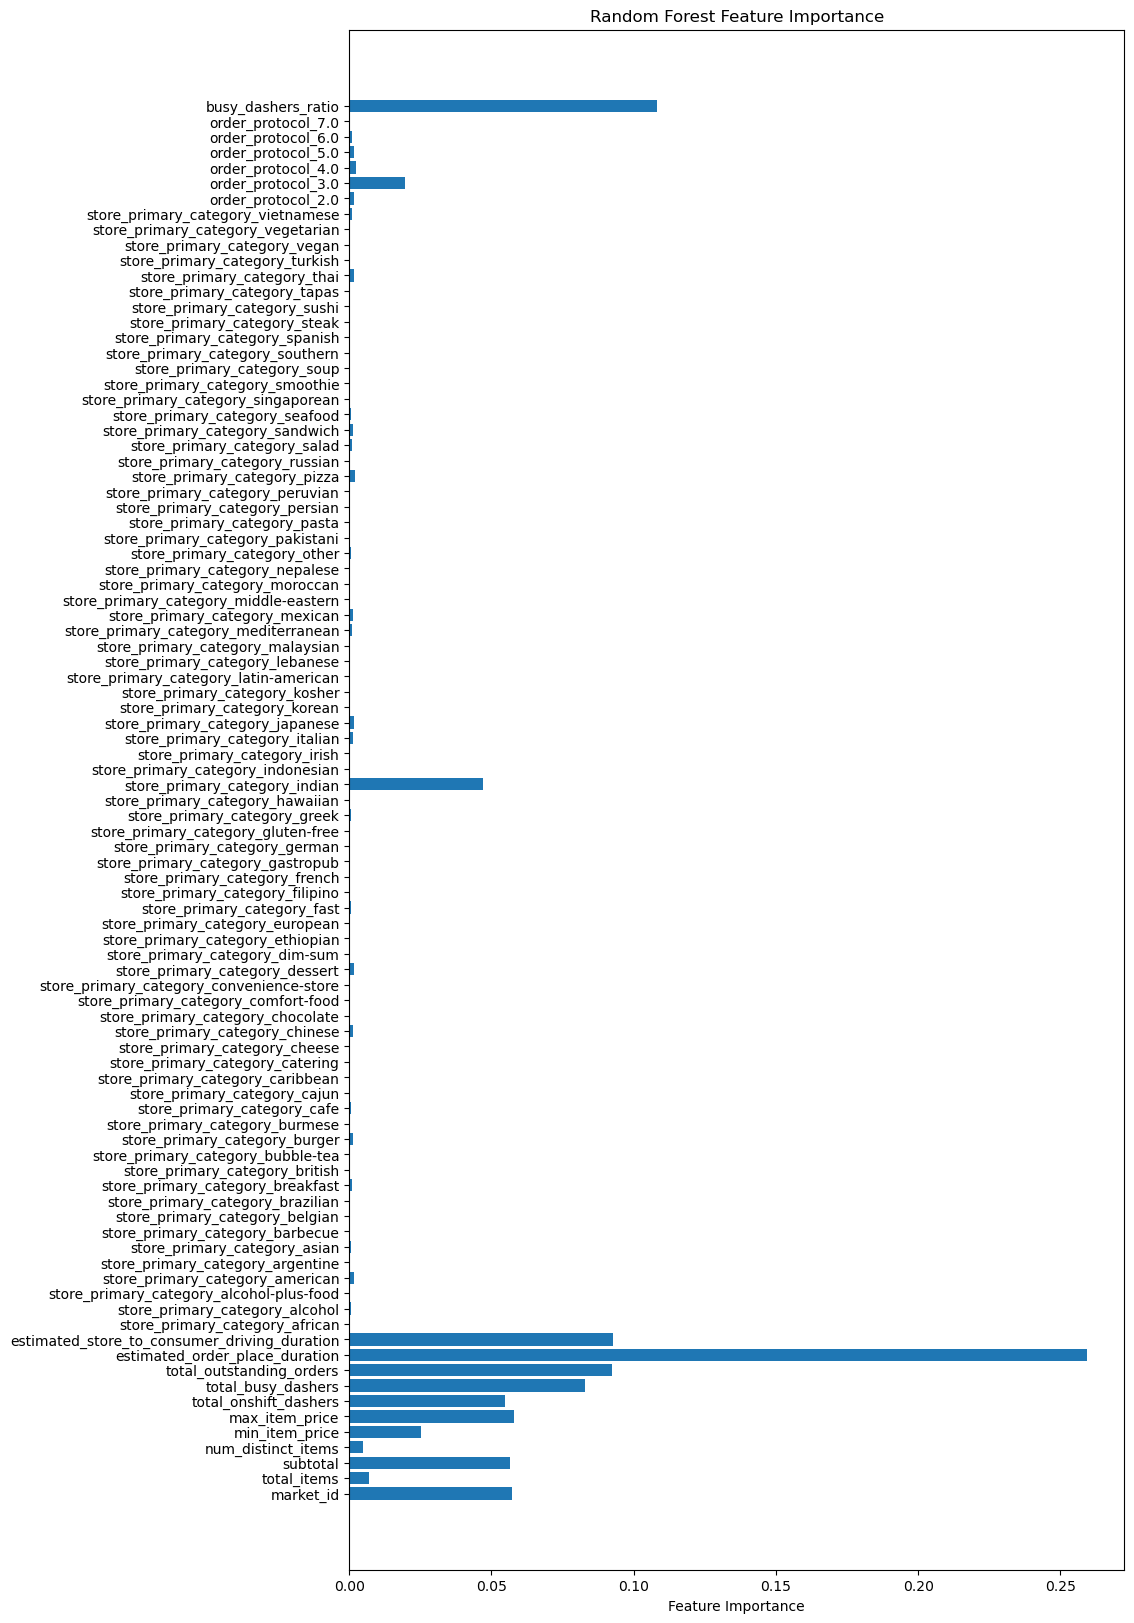

In [37]:
rf_feature_importance = rf_model.feature_importances_

# Plot Feature Importance for Random Forest
plt.figure(figsize=(10,20))
plt.barh(X.columns, rf_feature_importance)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()

#### 2. XGBoost

In [20]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

Making predictions using this model

In [21]:
y_pred_xgb = xgb_model.predict(X_test)

Evaluation

In [22]:
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")

XGBoost MAE: 873.498498678141


Feature Importance

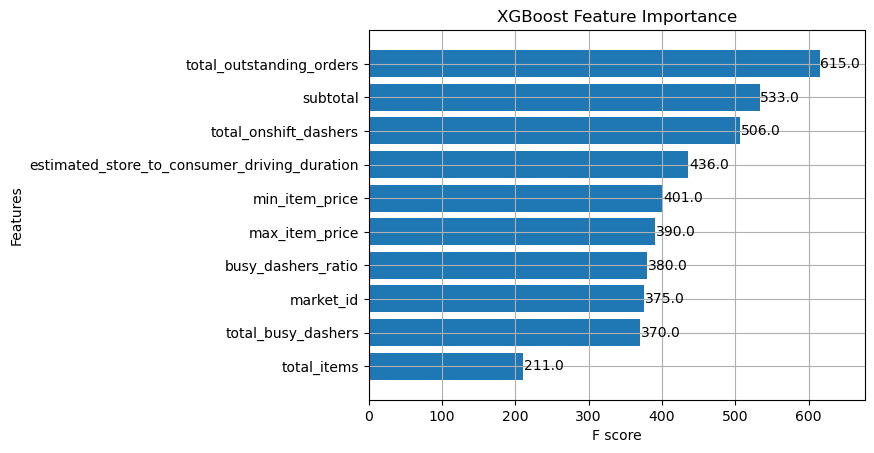

In [38]:
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10, title="XGBoost Feature Importance", height=0.8)
plt.show()

#### 3. K-Nearest-Neighbours (KNN)

In [23]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)

KNeighborsRegressor()

Lets make predictions using this model

In [24]:
y_pred_knn = knn_model.predict(X_test_scaled)

Model Evaluation

In [25]:
mae_knn = mean_absolute_error(y_test, y_pred_knn)
print(f"KNN MAE: {mae_knn}")

KNN MAE: 908.2389717614283


#### Lets compare the models

In [26]:
models_performance = {
    "Random Forest": mae_rf,
    "XGBoost": mae_xgb,
    "KNN": mae_knn
}

Finding the best model

In [27]:
best_model = min(models_performance, key=models_performance.get)
print(f"The best model is: {best_model} with MAE: {models_performance[best_model]}")

The best model is: Random Forest with MAE: 790.6558700595565


## 4. Model Inference

Now that we are done with all the steps, lets test our model

Let's assume we have some new data (here we will use a sample from the test set as an example).

We will use the best model for inference

In [39]:
new_data = X_test.iloc[0:5] #Example: taking first 5 rows of the test set as new data

In [40]:
new_data_scaled = scaler.transform(new_data) #performing standardization

In [45]:
# Convert the scaled data back to a pandas DataFrame with column names
new_data_scaled_df = pd.DataFrame(new_data_scaled, columns=new_data.columns)

In [46]:
best_model_inference = xgb_model if best_model == 'XGBoost' else rf_model if best_model == 'Random Forest' else knn_model

In [49]:
#Getting predictions
eta_predictions = best_model_inference.predict(new_data_scaled)

/Users/varunv/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [50]:
print("Predicted ETAs for new data (in seconds):")
print(eta_predictions)

Predicted ETAs for new data (in seconds):
[3266.92       3039.58666667 3062.41666667 2813.89666667 3219.16666667]
